In [1]:
import numpy as np
import pandas as pd
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from xgboost import plot_importance

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load data
- I'm using the files that were updated at **April 21st**
- ref : https://github.com/jihoo-kim/Data-Science-for-COVID-19

In [2]:
# Prepare dataset
Region_df = pd.read_csv('../dataset/Region_sido_addPop_addHospital.csv')[['province', 'safe_hospitals_count', 'infection_hospitals_count', 'infection_hospitals_bed_num']]
PatientInfo_df = pd.read_csv('../dataset/Patient/PatientInfo.csv')
print(f'PatientInfo.csv shape : {PatientInfo_df.shape}')

PatientInfo_df = PatientInfo_df[PatientInfo_df.state.isin(['released', 'deceased'])]
PatientInfo_df['confirmed_date'] = pd.to_datetime(PatientInfo_df['confirmed_date'])  # convert data type
print(f'      → datset shape : {PatientInfo_df.shape}')

display(PatientInfo_df.head(3))


# Save patient_id list
present_patients = PatientInfo_df.patient_id.astype(str).tolist()
with open('patients_id_0421.txt', 'w') as fp:
    fp.write('\n'.join(present_patients))

PatientInfo.csv shape : (3326, 18)
      → datset shape : (1704, 18)


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released


In [3]:
# Check Null values
PatientInfo_df.contact_number.value_counts(dropna=False, normalize=True) * 100
PatientInfo_df.symptom_onset_date.value_counts(dropna=False, normalize=True) * 100
PatientInfo_df.infection_order.value_counts(dropna=False, normalize=True) * 100
PatientInfo_df.disease.value_counts(dropna=False, normalize=True) * 100

NaN     98.943662
True     1.056338
Name: disease, dtype: float64

## 2. Preprocess data
- selected features : 'sex', 'birth_year', 'age', 'country', 'province', 'city', 'infection_case', 'confirmed_date'
- handling nan
    - drop nan from 'sex' & 'age'
    - replace with mean of same age group in birth_year
    - replace with mode in city (except for Daegu, Gwangju - replace with province)
    - replace with 'not-reported' in infection_case
- new features : 'years_after_birth', 'days_after_first_date'
    - (ohter new features were created but deleted after evaluation - 'days_after_first_date_province', 'province_safe_hospitals_count', 'province_infection_hospitals_count', 'province_infection_bed_count')
- feature encoding
    - age : convert to integer (0~10) - label encoding
    - other columns : one-hot encoding

In [4]:
# Select features
X_features = PatientInfo_df[['sex', 'birth_year', 'age', 'country', 'province', 'city', 'infection_case', 'confirmed_date']].copy()
y_target = PatientInfo_df[['state']].copy()

print(f'X_features.shape : {X_features.shape}')
print(f'y_target.shape : {y_target.shape}')
X_features.head(3)

X_features.shape : (1704, 8)
y_target.shape : (1704, 1)


,sex,birth_year,age,country,province,city,infection_case,confirmed_date
0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,overseas inflow,2020-01-23
1,male,1987.0,30s,Korea,Seoul,Jungnang-gu,overseas inflow,2020-01-30
2,male,1964.0,50s,Korea,Seoul,Jongno-gu,contact with patient,2020-01-30


In [5]:
print('\n<< no of nan table (before handling) >>')
print(X_features.isna().sum())

# Handle nan - sex & age
y_target = y_target[~X_features.sex.isna() & ~X_features.age.isna()]
X_features = X_features[~X_features.sex.isna() & ~X_features.age.isna()]

# Handle nan - birth_year
mean_year_list = dict(X_features.groupby('age')['birth_year'].mean().round().reset_index().values)
X_features.loc[X_features.birth_year.isna(), 'birth_year'] = X_features.loc[X_features.birth_year.isna(), 'age'].map( lambda x : mean_year_list[ x ] )

# Handle nan - city
mode_city_list = X_features.groupby(['province', 'city'])['infection_case'].count().\
        reset_index().sort_values('infection_case', ascending=False).\
        drop_duplicates('province').reset_index(drop=True)
mode_city_dict = dict(mode_city_list[['province', 'city']].values)
mode_city_dict['Daegu'] = 'Daegu'
mode_city_dict['Gwangju'] = 'Gwangju'
X_features.loc[X_features.city.isna(), 'city'] = X_features.loc[X_features.city.isna(), 'province'].map( lambda x : mode_city_dict[ x ] )

# Handle nan - infection_case
X_features.loc[X_features.infection_case.isna(), 'infection_case'] = 'not-reported'


print('\n<< no of nan table (after handling) >>')
print(X_features.isna().sum())


print(f'\n\nX_features.shape : {X_features.shape}')
print(f'y_target.shape : {y_target.shape}')


<< no of nan table (before handling) >>
sex                 7
birth_year        224
age                10
country             0
province            0
city               45
infection_case    582
confirmed_date      0
dtype: int64

<< no of nan table (after handling) >>
sex               0
birth_year        0
age               0
country           0
province          0
city              0
infection_case    0
confirmed_date    0
dtype: int64


X_features.shape : (1694, 8)
y_target.shape : (1694, 1)


In [7]:
# Create new features
X_features['years_after_birth'] = (datetime.date.today().year - X_features['birth_year']).astype(int)

X_features['days_after_first_date'] = X_features['confirmed_date'] - X_features['confirmed_date'].min()
X_features['days_after_first_date'] = X_features['days_after_first_date'].dt.days

## deleted after evaluation - days_after_first_date_province
# first_date_province_dict = dict(PatientInfo_df.groupby('province')['confirmed_date'].min().reset_index().values)
# X_features['first_date_province'] = X_features['province'].map( lambda x : first_date_province_dict[x] )
# X_features['days_after_first_date_province'] = X_features['confirmed_date'] - X_features['first_date_province']
# X_features['days_after_first_date_province'] = X_features['days_after_first_date_province'].dt.days

## deleted after evaluation - province infomations
# province_info_dict = { item_list[0]:item_list[1:] for item_list in Region_df.values }
# X_features['province_safe_hospitals_count'] = X_features.province.map(lambda x : province_info_dict[x][0])
# X_features['province_infection_hospitals_count'] = X_features.province.map(lambda x : province_info_dict[x][1])
# X_features['province_infection_bed_count'] = X_features.province.map(lambda x : province_info_dict[x][2])

X_features = X_features.drop(columns=['birth_year', 'confirmed_date'])

X_features.head(3)

,sex,age,country,province,city,infection_case,years_after_birth,days_after_first_date
0,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,56,3
1,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,33,10
2,male,50s,Korea,Seoul,Jongno-gu,contact with patient,56,10


In [8]:
# feature encoding - X_features
X_features_processed = X_features.copy()
X_features_processed = pd.concat([X_features_processed, pd.get_dummies(X_features_processed[['sex', 'country', 'province', 'city', 'infection_case']])], 
                                 axis=1)  # one-hot encoding
X_features_processed = X_features_processed.drop(columns=['sex', 'country', 'province', 'city', 'infection_case'])
X_features_processed['age'] = X_features.age.str.replace('s','').astype(int)//10  # label encoding

display(X_features_processed.head(3))
print()


# feature encoding - y_target
y_target_processed = pd.get_dummies(y_target)['state_deceased']
display(y_target_processed.head(3))

,age,years_after_birth,days_after_first_date,sex_female,sex_male,country_China,country_France,country_Indonesia,country_Korea,country_Mongolia,...,infection_case_River of Grace Community Church,infection_case_Seongdong-gu APT,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_not-reported,infection_case_overseas inflow
0,5,56,3,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,3,33,10,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,5,56,10,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


0    0
1    0
2    0
Name: state_deceased, dtype: uint8

## 3. Split data into train, val, test
- It's important that **labels are highly unbalanced** (only about 3% is deceased)
- Since the dataset is quite small(1704 records), I will split the date into **6:3:1** for now (test data could be added from the next file update)
- Since the labels are highly imbalanced, it's better to use **stratified random sampling**.

In [9]:
# Get train dataset
X_train, X_val_test, y_train, y_val_test = train_test_split(X_features_processed, y_target_processed, test_size=0.4, random_state=0, stratify=y_target)

# Get val & test dataset
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.25, random_state=0, stratify=y_val_test)


# Check the labels of each dataset
print('< Percentage of each label (whole dataset) >')
print(y_target_processed.value_counts(normalize=True) * 100)

print('\n< Percentage of each label (Train dataset) > - size of dataset :', y_train.shape[0])
print(y_train.value_counts(normalize=True) * 100)

print('\n< Percentage of each label (Validation dataset) > - size of dataset :', y_val.shape[0])
print(y_val.value_counts(normalize=True) * 100)

print('\n< Percentage of each label (Test dataset) > - size of dataset :', y_test.shape[0])
print(y_test.value_counts(normalize=True) * 100)

< Percentage of each label (whole dataset) >
0    96.044864
1     3.955136
Name: state_deceased, dtype: float64

< Percentage of each label (Train dataset) > - size of dataset : 1016
0    96.062992
1     3.937008
Name: state_deceased, dtype: float64

< Percentage of each label (Validation dataset) > - size of dataset : 508
0    96.062992
1     3.937008
Name: state_deceased, dtype: float64

< Percentage of each label (Test dataset) > - size of dataset : 170
0    95.882353
1     4.117647
Name: state_deceased, dtype: float64


## 4. Train model - XGBoost

In [10]:
# Train model
xgb_wrapper = XGBClassifier(random_state=0)
xgb_wrapper.fit(X_train, y_train)


# Evaluate model
def get_clf_eval(y_test , pred):
    from sklearn.metrics import confusion_matrix, accuracy_score
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import f1_score, roc_auc_score

    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    pass

xgb_preds = xgb_wrapper.predict(X_val)
get_clf_eval(y_val , xgb_preds)

오차 행렬
[[487   1]
 [  8  12]]
정확도: 0.9823, 정밀도: 0.9231, 재현율: 0.6000,    F1: 0.7273, AUC:0.7990


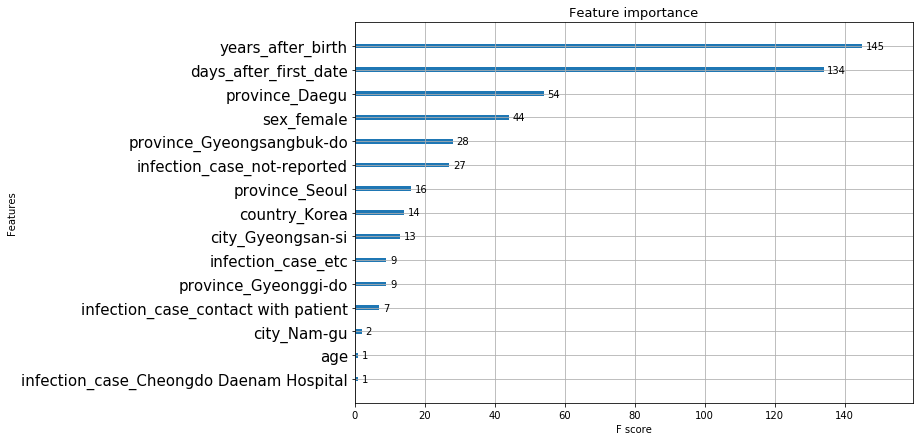

In [11]:
# Visualize the feature importance
fig, ax = plt.subplots(figsize=(10, 7))
plot_importance(xgb_wrapper, ax=ax)
ax.set_title('Feature importance', size=13)
ax.tick_params(axis='y', labelsize=15)

plt.show()